## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

from datetime import date, timedelta,datetime
from dateutil import easter
from dateutil.relativedelta import *

import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GroupKFold, cross_val_score, KFold, train_test_split



## Additional functions

In [2]:
# get holidays in given year(s)

def get_holidays(year):
    easter_sunday = easter.easter(year)
    holidays = [date(year,1,1),
                date(year,1,6),
                easter_sunday,
                easter_sunday + timedelta(days=1),
                date(year,5,1),
                date(year,5,3),
                # 7th Sunday after Easter
                # (notice days+1 - this is 7th Sunday excluding Easter Sunday
                easter_sunday + relativedelta(days=+1, weekday=SU(+7)),
                # 9th Thursday after Easter
                easter_sunday + relativedelta(weekday=TH(+9)),
                date(year,8,15),
                date(year,11,1),
                date(year,11,11),
                date(year, 12, 25),
                date(year, 12, 26),
               ]
    return holidays

## Get data

In [3]:
#gas consumption data

df = pd.read_excel("sample_data.xls", usecols=["date","value"])
df["date"] = pd.to_datetime(df["date"])
df = df[df["date"]<"2022.03.01"]

#sum hourly data to get daily consumption
df=df.set_index("date").resample("1D").sum().reset_index()


In [4]:
#get meteo data
df_meteo = pd.read_csv("2018_2022_hourly_meteo_data.csv", parse_dates=[1])

#get data for only one weather station (gas recipient's city)
df_meteo = df_meteo[df_meteo["station_id"] == 353230295]
df_meteo.info()

#get daily average temperature and wind speed 
df_d = df_meteo[["date", "temp","wind"]].set_index("date").resample("1D").mean()

#avg for day of year - dict
df_meteo["dayofyear"] = df_meteo["date"].dt.dayofyear
df_t = df_meteo.groupby(["dayofyear"])[["temp","wind"]].agg("mean").to_dict()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36480 entries, 8264487 to 8300966
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   station_id  36480 non-null  int64         
 1   date        36480 non-null  datetime64[ns]
 2   temp        36478 non-null  float64       
 3   wind        36329 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.4 MB


## Features

In [5]:
def feature_engineering(df):

    #timeseries features
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["hour"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["weekofyear"] = df["date"].dt.weekofyear
    df["is_holiday"] = df["date"].apply(lambda x: int(x in holidays))
    df["is_weekend"] = df["dayofweek"].apply(lambda x: int(x>=5))
    df["is_weekday"] = df["dayofweek"].apply(lambda x: int(x<5))
    df["quarter"]=df["date"].dt.quarter
    df["is_month_start"] = df["date"].dt.is_month_start.astype("int")
    df["is_month_end"] = df["date"].dt.is_month_end.astype("int")
    df["is_day_before_holiday"] = df["date"].apply(lambda x: int(x+timedelta(days=1) in holidays))
    df["is_day_after_holiday"] = df["date"].apply(lambda x: int(x-timedelta(days=1) in holidays))
    
    
  #meteo
    df["date_avg_temp"] = df["date"].apply(lambda x: df_d.loc[x, "temp"])
    df["date_avg_wind"] = df["date"].apply(lambda x: df_d.loc[x, "wind"])
  
  #avg for day of year
    df["day_avg_temp"] = df["dayofyear"].apply(lambda x: df_t.get("temp").get(x))
    df["day_avg_wind"] = df["dayofyear"].apply(lambda x: df_t.get("wind").get(x))

    df["prev_day_avg_temp"] = df["dayofyear"].apply(lambda x: df_t.get("temp").get(x-1))
    df["prev_day_avg_wind"] = df["dayofyear"].apply(lambda x: df_t.get("wind").get(x-1))    



    return df
    


In [6]:
holidays = [get_holidays(x) for x in range(2018,2023)]
holidays = [i for sublist in holidays for i in sublist]
df_new = feature_engineering(df.copy()).reset_index()

C:\Users\pawel.piekaj\AppData\Local\Temp\ipykernel_23068\3416385576.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["weekofyear"] = df["date"].dt.weekofyear
C:\Users\pawel.piekaj\AppData\Local\Temp\ipykernel_23068\3416385576.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df["is_holiday"] = df["date"].apply(lambda x: int(x in holidays))
C:\Users\pawel.piekaj\AppData\Local\Temp\ipykernel_23068\3416385576.py:17: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df["is_day_before_holiday"] = df["date"].a

## X i y

In [7]:
feats = [ "day", "month", "dayofweek", "dayofyear", "weekofyear","quarter"]
feats+= ["day_avg_temp", "day_avg_wind","prev_day_avg_temp", "prev_day_avg_wind", "date_avg_temp","date_avg_wind"]
feats += ["is_month_start","is_month_start","is_weekend","is_weekday","is_day_before_holiday","is_day_after_holiday"]



df_test = df_new[(df_new["date"]>="2021.11.01") & (df["date"]<"2022.03.01")].copy()
df_train = df_new[(df_new["date"]>="2019.01.01") & (df["date"]<"2021.11.01") ].copy()
df_test_cp = df_test.copy()
df_test["value"] = np.nan

X_train = df_train[feats].values
y_train = df_train["value"].values
X_test = df_test[feats].values


## XGBoost

In [8]:
cv = KFold(n_splits=5)
model = xgb.XGBRegressor(max_depth=7, n_estimators=100, learning_rate=0.1, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-5.027740582575626, 1.4840476153163937)

In [9]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[y_pred<0] = 0

In [10]:
df_test_cp["pred_value"] = y_pred
mean_absolute_error(df_test_cp.value, df_test_cp.pred_value)

5.1822276347875595

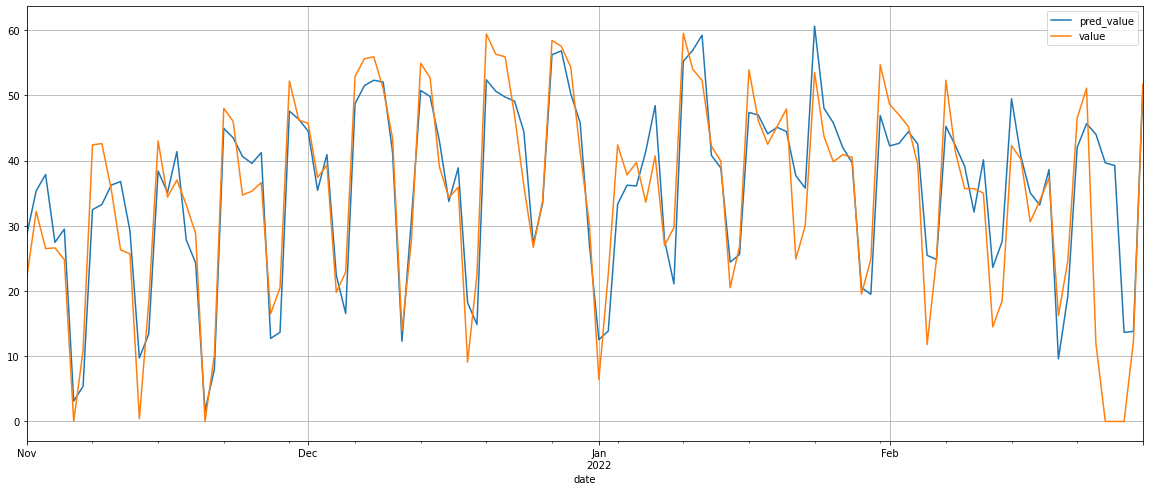

In [11]:
df_plot = df_test_cp.set_index("date")
df_plot["pred_value"].plot()
df_plot["value"].plot( figsize=(20,8), grid=True )
plt.legend();